In [1]:
import numpy as np
import pandas as pd 
import xgboost as xgb
import matplotlib.pyplot as plt
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import datetime
import xlrd
import os
import re
from scipy.stats import kstest
from scipy.spatial.distance import directed_hausdorff
from scipy import optimize
import pwlf
from scipy.optimize import minimize
from pyecharts import options as opts
from pyecharts.charts import Calendar
from matplotlib.ticker import FuncFormatter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import math
from sklearn.exceptions import ConvergenceWarning
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import contextlib

In [2]:
# load real capacity data from E:\day-ahead price\Data\ISO_New_England\real_capacity
path = r'E:\day-ahead price\Data\ISO_New_England\real_capacity'
os.chdir(path)
files = os.listdir(path)
df_peak_load = pd.DataFrame()
df_capa = pd.DataFrame()
df_interchange = pd.DataFrame()
for file in files:
    delimiter = ','
    max_columns = max(open(file), key=lambda x: x.count(delimiter)).count(delimiter)
    df_tmp = pd.read_csv(file, header=None, names=list(range(max_columns+1)))
    df_tmp = df_tmp.iloc[8:50, :].reset_index(drop=True)

    prior_date = pd.to_datetime(df_tmp.iloc[1, 1])
    Hour_Ending = int(df_tmp.iloc[1, 2])
    peak_load = float(df_tmp.iloc[1, 3])
    df_peak_load = pd.concat([df_peak_load, pd.DataFrame([[prior_date, Hour_Ending, peak_load]], columns=['Date', 'Hour Ending', 'Peak Load'])], axis=0)

    report_date = prior_date + datetime.timedelta(1)
    Capacity_Supply_Obligation = float(df_tmp.iloc[4, 2])
    Capacity_Additions_EcoMax_Bid_CSO = float(df_tmp.iloc[5, 2])	
    Generation_Outages_and_Reductions = float(df_tmp.iloc[6, 2])
    Uncommitted_Available_Generation = float(df_tmp.iloc[7, 2])
    DRR_Capacity = float(df_tmp.iloc[8, 2])
    Uncommitted_Available_DRR = float(df_tmp.iloc[9, 2])
    Net_Deliveries = float(df_tmp.iloc[17, 2])
    Total_Available_Capacity = float(df_tmp.iloc[18, 2])
    Peak_Load_Forecast = float(df_tmp.iloc[19, 2])
    Total_Operating_Reserve_Requirements = float(df_tmp.iloc[20, 2])
    Capacity_Required = float(df_tmp.iloc[21, 2])
    Surplus_Deficiency = float(df_tmp.iloc[22, 2])
    Replacement_Reserve_Requirement = float(df_tmp.iloc[23, 2])
    Excess_Commitment_Surplus_Deficiency = float(df_tmp.iloc[24, 2])
    df_capa = pd.concat([df_capa, pd.DataFrame([[report_date, Hour_Ending, Capacity_Supply_Obligation, Capacity_Additions_EcoMax_Bid_CSO, Generation_Outages_and_Reductions, Uncommitted_Available_Generation, DRR_Capacity, Uncommitted_Available_DRR, Net_Deliveries, Total_Available_Capacity, Peak_Load_Forecast, Total_Operating_Reserve_Requirements, Capacity_Required, Surplus_Deficiency, Replacement_Reserve_Requirement, Excess_Commitment_Surplus_Deficiency]], columns=['Date', 'Hour Ending', 'Capacity Supply Obligation', 'Capacity Additions EcoMax Bid CSO', 'Generation Outages and Reductions', 'Uncommitted Available Generation', 'DRR Capacity', 'Uncommitted Available DRR', 'Net Deliveries', 'Total Available Capacity', 'Peak Load Forecast', 'Total Operating Reserve Requirements', 'Capacity Required', 'Surplus Deficiency', 'Replacement Reserve Requirement', 'Excess Commitment Surplus Deficiency'])], axis=0)

    tmp_interchange = df_tmp.iloc[35:, 1:].reset_index(drop=True)
    tmp_interchange.columns = tmp_interchange.iloc[0]
    tmp_interchange = tmp_interchange.iloc[1:, :].reset_index(drop=True)
    tmp_interchange['Date'] = report_date
    df_interchange = pd.concat([df_interchange, tmp_interchange], axis=0)
    
df_peak_load = df_peak_load.drop_duplicates(subset=['Date'], keep='first').reset_index(drop=True)
df_capa = df_capa.drop_duplicates(subset=['Date'], keep='first').reset_index(drop=True)
df_interchange = df_interchange.drop_duplicates(subset=['Date', 'Description'], keep='first').reset_index(drop=True)
df_capa

,Date,Hour Ending,Capacity Supply Obligation,Capacity Additions EcoMax Bid CSO,Generation Outages and Reductions,Uncommitted Available Generation,DRR Capacity,Uncommitted Available DRR,Net Deliveries,Total Available Capacity,Peak Load Forecast,Total Operating Reserve Requirements,Capacity Required,Surplus Deficiency,Replacement Reserve Requirement,Excess Commitment Surplus Deficiency
0,2022-01-01,18,29741.0,1491.0,2621.0,13055.0,233.0,12.0,-3394.0,19171.0,14220.0,2209.0,16429.0,2742.0,180.0,2562.0
1,2022-01-02,18,29741.0,1970.0,1930.0,13834.0,232.0,12.0,-3088.0,19255.0,15400.0,2209.0,17609.0,1646.0,180.0,1466.0
2,2022-01-03,18,29741.0,2124.0,1806.0,11739.0,331.0,12.0,-2794.0,21433.0,18000.0,2209.0,20209.0,1224.0,180.0,1044.0
3,2022-01-04,18,29741.0,1867.0,2509.0,11443.0,322.0,12.0,-3146.0,21112.0,17570.0,2209.0,19779.0,1333.0,180.0,1153.0
4,2022-01-05,18,29741.0,1817.0,2524.0,9464.0,325.0,12.0,-1837.0,21720.0,16700.0,2209.0,18909.0,2811.0,180.0,2631.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,2023-11-07,18,28377.0,1129.0,9637.0,4125.0,220.0,12.0,-2401.0,18353.0,14500.0,2108.0,16608.0,1745.0,180.0,1565.0
676,2023-11-08,18,28377.0,1769.0,8918.0,4023.0,220.0,12.0,-2383.0,19796.0,15280.0,2053.0,17333.0,2463.0,180.0,2283.0
677,2023-11-09,18,28377.0,974.0,9639.0,3207.0,226.0,12.0,-2002.0,18721.0,15360.0,2110.0,17470.0,1251.0,180.0,1071.0
678,2023-11-10,18,28377.0,1268.0,9118.0,4559.0,224.0,12.0,-2145.0,18325.0,14830.0,2068.0,16898.0,1427.0,180.0,1247.0


In [3]:
# load real load data from E:\day-ahead price\Data\ISO_New_England\real_load
path = r'E:\day-ahead price\Data\ISO_New_England\real_load'
os.chdir(path)
files = os.listdir(path)
df_real_load = pd.DataFrame()
for file in files:
    delimiter = ','
    max_columns = max(open(file), key=lambda x: x.count(delimiter)).count(delimiter)
    df_tmp = pd.read_csv(file, header=None, names=list(range(max_columns+1)))
    df_tmp.columns = df_tmp.iloc[4]
    df_tmp = df_tmp[df_tmp['H'] == 'D'].iloc[:, 1:].reset_index(drop=True)
    df_tmp['Date'] = pd.to_datetime(df_tmp['Date'])
    df_tmp = df_tmp[df_tmp['Hour Ending'] != '02X']
    df_tmp['Hour Ending'] = df_tmp['Hour Ending'].astype(int)
    df_tmp['Day-Ahead Cleared Demand'] = df_tmp['Day-Ahead Cleared Demand'].astype(float)
    df_real_load = pd.concat([df_real_load, df_tmp], axis=0)
df_real_load

4,Date,Hour Ending,Day-Ahead Cleared Demand
0,2022-10-01,1,9518.0
1,2022-10-01,2,9639.0
2,2022-10-01,3,9445.0
3,2022-10-01,4,9317.0
4,2022-10-01,5,9460.0
...,...,...,...
356,2023-11-11,20,13427.0
357,2023-11-11,21,13145.0
358,2023-11-11,22,12383.0
359,2023-11-11,23,11749.0


In [4]:
# df_real_load lack a line of data in Date 2023-03-12, Hour Ending 3, so we need to add this line by average of Hour Ending 2 and Hour Ending 4
df_tmp = df_real_load[(df_real_load['Date'] == '2023-03-12') & (df_real_load['Hour Ending'] == 2)].reset_index(drop=True)
df_tmp['Hour Ending'] = 3
df_tmp['Day-Ahead Cleared Demand'] = (df_real_load[(df_real_load['Date'] == '2023-03-12') & (df_real_load['Hour Ending'] == 2)]['Day-Ahead Cleared Demand'].values + df_real_load[(df_real_load['Date'] == '2023-03-12') & (df_real_load['Hour Ending'] == 4)]['Day-Ahead Cleared Demand'].values) / 2
df_real_load = pd.concat([df_real_load, df_tmp], axis=0).reset_index(drop=True).sort_values(by=['Date', 'Hour Ending']).reset_index(drop=True)
df_real_load

4,Date,Hour Ending,Day-Ahead Cleared Demand
0,2022-10-01,1,9518.0
1,2022-10-01,2,9639.0
2,2022-10-01,3,9445.0
3,2022-10-01,4,9317.0
4,2022-10-01,5,9460.0
...,...,...,...
9763,2023-11-11,20,13427.0
9764,2023-11-11,21,13145.0
9765,2023-11-11,22,12383.0
9766,2023-11-11,23,11749.0


In [5]:
# load forecast capacity data from E:\day-ahead price\Data\ISO_New_England\forecast_capacity
path = r'E:\day-ahead price\Data\ISO_New_England\forecast_capacity'
os.chdir(path)
files = os.listdir(path)
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df_temp_pred = pd.DataFrame()
for file in files:
    delimiter = ','
    max_columns = max(open(file), key=lambda x: x.count(delimiter)).count(delimiter)
    df_tmp = pd.read_csv(file, header=None, names=list(range(max_columns+1)))
    temp_b, temp_h = df_tmp.iloc[8, 2], df_tmp.iloc[10, 2]
    df_tmp = df_tmp.iloc[6:27, 1:4].T
    df_tmp.columns = df_tmp.iloc[0]
    df_tmp = df_tmp.drop(['Weather', 'High Temperature - Boston', 'Dew Point - Boston', 'High Temperature - Hartford', 'Dew Point - Hartford', 'Generating Capacity Position'], axis=1).reset_index(drop=True).iloc[1:,:]
    df_tmp['Date'] = pd.to_datetime(df_tmp['Date'])
    df_tmp['Total Capacity Supply Obligation (CSO)'] = df_tmp['Total Capacity Supply Obligation (CSO)'].astype(float)
    df_tmp['Anticipated Cold Weather Outages'] = df_tmp['Anticipated Cold Weather Outages'].astype(float)
    df_tmp['Other Generation Outages'] = df_tmp['Other Generation Outages'].astype(float)
    df_tmp['Anticipated De-List MW Offered'] = df_tmp['Anticipated De-List MW Offered'].astype(float)
    df_tmp['Total Generation Available'] = df_tmp['Total Generation Available'].astype(float)
    df_tmp['Import at Time of Peak'] = df_tmp['Import at Time of Peak'].astype(float)
    df_tmp['Total Available Generation and Imports'] = df_tmp['Total Available Generation and Imports'].astype(float)
    df_tmp['Projected Peak Load'] = df_tmp['Projected Peak Load'].astype(float)
    df_tmp['Replacement Reserve Requirement'] = df_tmp['Replacement Reserve Requirement'].astype(float)
    df_tmp['Required Reserve'] = df_tmp['Required Reserve'].astype(float)
    df_tmp['Required Reserve including Replacement'] = df_tmp['Required Reserve including Replacement'].astype(float)
    df_tmp['Total Load plus Required Reserve'] = df_tmp['Total Load plus Required Reserve'].astype(float)
    df_tmp['Projected Surplus/(Deficiency)'] = df_tmp['Projected Surplus/(Deficiency)'].astype(float)
    df_tmp['Available Demand Response Resources'] = df_tmp['Available Demand Response Resources'].astype(float)
    column_name = df_tmp.columns
    df1 = pd.concat([df1, df_tmp.iloc[0, :]], axis=1)
    df2 = pd.concat([df2, df_tmp.iloc[1, :]], axis=1)
    df_temp_pred = pd.concat([df_temp_pred, pd.DataFrame([pd.to_datetime(df_tmp.iloc[0, 0]), temp_b, temp_h])], axis=1)  #pd.DataFrame([pd.to_datetime(df_tmp.iloc[0, 1]), temp_b, temp_h])
df1 = df1.T
df2 = df2.T
df1.columns = column_name
df2.columns = column_name
df1.drop_duplicates(subset=['Date'], keep='first', inplace=True)
df2.drop_duplicates(subset=['Date'], keep='first', inplace=True)
df_capa_pred_D1 = df1.reset_index(drop=True)
df_capa_pred_D2 = df2.reset_index(drop=True)
df_capa_pred_D1

1,Date,Total Capacity Supply Obligation (CSO),Anticipated Cold Weather Outages,Other Generation Outages,Anticipated De-List MW Offered,Total Generation Available,Import at Time of Peak,Total Available Generation and Imports,Projected Peak Load,Replacement Reserve Requirement,Required Reserve,Required Reserve including Replacement,Total Load plus Required Reserve,Projected Surplus/(Deficiency),Available Demand Response Resources
0,2022-10-01,28072.0,0.0,9388.0,1683.0,20367.0,3195.0,23562.0,13250.0,160.0,2303.0,2463.0,15713.0,7849.0,378.0
1,2022-10-02,28072.0,0.0,8530.0,1347.0,20889.0,3195.0,24084.0,13500.0,160.0,2303.0,2463.0,15963.0,8121.0,295.0
2,2022-10-03,28072.0,0.0,8672.0,1541.0,20941.0,3425.0,24366.0,14020.0,160.0,2303.0,2463.0,16483.0,7883.0,273.0
3,2022-10-04,28072.0,0.0,8673.0,1367.0,20766.0,3425.0,24191.0,14500.0,160.0,2303.0,2463.0,16963.0,7228.0,378.0
4,2022-10-05,28072.0,0.0,7819.0,1458.0,21711.0,3525.0,25236.0,14420.0,160.0,2303.0,2463.0,16883.0,8353.0,382.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,2023-11-08,28377.0,0.0,10394.0,1243.0,19226.0,3295.0,22521.0,15280.0,180.0,2303.0,2483.0,17763.0,4758.0,342.0
401,2023-11-09,28377.0,0.0,10998.0,1731.0,19110.0,3295.0,22405.0,15360.0,180.0,2303.0,2483.0,17843.0,4562.0,343.0
402,2023-11-10,28377.0,0.0,11241.0,962.0,18098.0,3295.0,21393.0,14830.0,180.0,2303.0,2483.0,17313.0,4080.0,355.0
403,2023-11-11,28377.0,0.0,9945.0,1209.0,19641.0,3095.0,22736.0,14430.0,180.0,2303.0,2483.0,16913.0,5823.0,353.0


In [6]:
df_temp_pred = df_temp_pred.T
df_temp_pred.columns = ['Date', 'Boston', 'Hartford']
df_temp_pred['Date'] = pd.to_datetime(df_temp_pred['Date'])
df_temp_pred['Boston'] = df_temp_pred['Boston'].astype(float)
df_temp_pred['Hartford'] = df_temp_pred['Hartford'].astype(float)
df_temp_pred.drop_duplicates(subset=['Date'], keep='first', inplace=True)
df_temp_pred.fillna(method='ffill', inplace=True)
# df_temp_pred lack a line of data in Date 2022-12-26, so we need to add this line by average of Date 2022-12-25 and Date 2022-12-27
df_tmp = df_temp_pred[df_temp_pred['Date'] == '2022-12-25'].reset_index(drop=True)
df_tmp['Date'] = pd.to_datetime('2022-12-26')
df_tmp['Boston'] = (df_temp_pred[df_temp_pred['Date'] == '2022-12-25']['Boston'].values + df_temp_pred[df_temp_pred['Date'] == '2022-12-27']['Boston'].values) / 2
df_tmp['Hartford'] = (df_temp_pred[df_temp_pred['Date'] == '2022-12-25']['Hartford'].values + df_temp_pred[df_temp_pred['Date'] == '2022-12-27']['Hartford'].values) / 2
df_temp_pred = pd.concat([df_temp_pred, df_tmp], axis=0).reset_index(drop=True).sort_values(by=['Date']).reset_index(drop=True)
df_temp_pred

,Date,Boston,Hartford
0,2022-10-01,57.0,57.0
1,2022-10-02,55.0,59.0
2,2022-10-03,55.0,60.0
3,2022-10-04,56.0,58.0
4,2022-10-05,57.0,61.0
...,...,...,...
401,2023-11-08,50.0,47.0
402,2023-11-09,47.0,50.0
403,2023-11-10,52.0,52.0
404,2023-11-11,47.0,49.0


In [7]:
# load forecast load data from E:\day-ahead price\Data\ISO_New_England\forecast_load
path = r'E:\day-ahead price\Data\ISO_New_England\forecast_load'
os.chdir(path)
files = os.listdir(path)
tmp1 = []
tmp2 = []
for file in files:
    delimiter = ','
    max_columns = max(open(file), key=lambda x: x.count(delimiter)).count(delimiter)
    df_tmp = pd.read_csv(file, header=None, names=list(range(max_columns+1)))
    # print(df_tmp)
    df_tmp.columns = df_tmp.iloc[4]
    df_tmp = df_tmp.iloc[6:]
    df_tmp = df_tmp[df_tmp['H'] == 'D'].drop(['H'], axis=1).reset_index(drop=True)
    df_tmp['Published Date'] = pd.to_datetime(df_tmp['Published Date'])
    df_tmp['Forecast Date'] = pd.to_datetime(df_tmp['Forecast Date'])
    df_tmp['Published Day'] = df_tmp['Published Date'].dt.strftime('%Y-%m-%d')
    df_tmp['Published Day'] = pd.to_datetime(df_tmp['Published Day'])
    df_tmp['delta'] = df_tmp['Forecast Date'] - df_tmp['Published Day']
    df_tmp['MW'] = df_tmp['MW'].astype(float)
    df_tmp['%'] = df_tmp['%'].astype(float)
    df_tmp1 = df_tmp[df_tmp['delta'] == datetime.timedelta(1)].reset_index(drop=True)
    df_tmp2 = df_tmp[df_tmp['delta'] == datetime.timedelta(2)].reset_index(drop=True)
    df_tmp1.drop_duplicates(subset=['Forecast Date', 'Hour', 'Reliability Region'], keep='first', inplace=True)
    df_tmp2.drop_duplicates(subset=['Forecast Date', 'Hour', 'Reliability Region'], keep='first', inplace=True)
    df_group1 = df_tmp1.groupby(['Forecast Date', 'Hour'])
    
    for [Forecast_Date, Hour], group in df_group1:
        Load = group['MW'].sum()
        percent = group['%'].sum()
        if percent > 90:
            tmp1.append([Forecast_Date, Hour, Load])
    df_group2 = df_tmp2.groupby(['Forecast Date', 'Hour'])
    for [Forecast_Date, Hour], group in df_group2:
        Load = group['MW'].sum()
        percent = group['%'].sum()
        if percent > 90:
            tmp2.append([Forecast_Date, Hour, Load])
df_load_pred_D1 = pd.DataFrame(tmp1, columns=['Forecast Date', 'Hour', 'Load(MW)'])
df_load_pred_D2 = pd.DataFrame(tmp2, columns=['Forecast Date', 'Hour', 'Load(MW)'])
df_load_pred_D1['Date'] = df_load_pred_D1['Forecast Date']
df_load_pred_D2['Date'] = df_load_pred_D2['Forecast Date']
df_load_pred_D1 = df_load_pred_D1[df_load_pred_D1['Hour'] != '02X']
df_load_pred_D2 = df_load_pred_D2[df_load_pred_D2['Hour'] != '02X']
df_load_pred_D1['Hour Ending'] = df_load_pred_D1['Hour'].astype(int)
df_load_pred_D2['Hour Ending'] = df_load_pred_D2['Hour'].astype(int)
df_load_pred_D1

,Forecast Date,Hour,Load(MW),Date,Hour Ending
0,2022-10-01,01,9850.000,2022-10-01,1
1,2022-10-01,02,9410.001,2022-10-01,2
2,2022-10-01,03,9190.000,2022-10-01,3
3,2022-10-01,04,9110.000,2022-10-01,4
4,2022-10-01,05,9140.001,2022-10-01,5
...,...,...,...,...,...
9764,2023-11-11,20,13819.999,2023-11-11,20
9765,2023-11-11,21,13249.999,2023-11-11,21
9766,2023-11-11,22,12730.000,2023-11-11,22
9767,2023-11-11,23,12020.000,2023-11-11,23


In [11]:
df_timesnetpred = pd.read_csv(r'E:\day-ahead price\Code\Time-Series-Library-main\Results\iso capacity\capacity_timesnet.csv')
df_timesnetpred['Date'] = pd.to_datetime(df_timesnetpred['date'])
df_timesnetpred

,date,mae,smape,pred,true,Date
0,2022-09-30,1735.238300,0.094876,19157.238,17422.0,2022-09-30
1,2022-10-01,2439.072300,0.140350,18598.072,16159.0,2022-10-01
2,2022-10-02,1298.134800,0.072773,18487.135,17189.0,2022-10-02
3,2022-10-03,1655.826200,0.094852,18284.826,16629.0,2022-10-03
4,2022-10-04,115.197266,0.006368,18032.803,18148.0,2022-10-04
...,...,...,...,...,...,...
360,2023-09-25,71.996090,0.004068,17735.996,17664.0,2023-09-25
361,2023-09-26,335.255860,0.018841,17626.744,17962.0,2023-09-26
362,2023-09-27,991.244140,0.057378,17771.244,16780.0,2023-09-27
363,2023-09-28,381.248050,0.022153,17400.248,17019.0,2023-09-28


In [8]:
def loss(target, prediction):
    if np.size(target) == 0 or np.size(prediction) == 0:
        return 0, 0, 0, 0
    from math import sqrt
    error = []
    pError = []
    for i in range(len(target)):
        error.append(target[i] - prediction[i])
        
        # if target[i] < 55:
        #     a = 55
        # else:
        #     a = target[i]
        # if prediction[i] < 55:
        #     b = 55
        # else:
        #     b = prediction[i]
        pError.append(abs(target[i] - prediction[i]) / ((abs(target[i]) + abs(prediction[i]))/2))

    squaredError = []
    absError = []
    for val in error:
        squaredError.append(val * val)#target-prediction之差平方 
        absError.append(abs(val))#误差绝对值
    mse = sum(squaredError) / len(squaredError)#均方误差MSE
    rmse = sqrt(sum(squaredError) / len(squaredError))#均方根误差RMSE
    mae = sum(absError) / len(absError)#平均绝对误差MAE
    smape = sum(pError) / len(absError)
    return mse, rmse, mae, smape

In [ ]:
# df4pred

def get_x_and_y(tgt_day):
    dminus1 = tgt_day - datetime.timedelta(1)
    dminus2 = tgt_day - datetime.timedelta(2)
    dminus3 = tgt_day - datetime.timedelta(3)
    dplus1 = tgt_day + datetime.timedelta(1)
    x = []
    trend = []
    for _ in pd.date_range(tgt_day - datetime.timedelta(9),tgt_day - datetime.timedelta(2)):
        trend.append(int(df_capa[df_capa['Date'] == _]['Total Available Capacity']))
    trend = pd.Series(trend).rolling(5,min_periods=1,center=True).mean().tolist()
    trend = [trend[-5], trend[-3], trend[-1]]
    x += trend
    tmp = df_load_pred_D1[df_load_pred_D1['Date'] == tgt_day]['Load(MW)']
    tmp1 = df_load_pred_D2[df_load_pred_D2['Date'] == dplus1]['Load(MW)']
    tmp2 = df_real_load[df_real_load['Date'] == dminus1]['Day-Ahead Cleared Demand']
    tmp3 = df_real_load[df_real_load['Date'] == dminus2]['Day-Ahead Cleared Demand']
    tmp4 = df_real_load[df_real_load['Date'] == dminus3]['Day-Ahead Cleared Demand']
    gap = [tmp.min(), tmp.max(), tmp.mean()]
    gap1 = [tmp1.min(), tmp1.max(), tmp1.mean()]
    gap2 = [tmp2.min(), tmp2.max(), tmp2.mean()]
    gap3 = [tmp3.min(), tmp3.max(), tmp3.mean()]
    gap4 = [tmp4.min(), tmp4.max(), tmp4.mean()]
    gap = pd.DataFrame(gap).fillna(method = 'bfill')[0].tolist()
    gap1 = pd.DataFrame(gap1).fillna(method = 'bfill')[0].tolist()
    gap2 = pd.DataFrame(gap2).fillna(method = 'bfill')[0].tolist()
    gap3 = pd.DataFrame(gap3).fillna(method = 'bfill')[0].tolist()
    gap4 = pd.DataFrame(gap4).fillna(method = 'bfill')[0].tolist()
    x += np.subtract(gap, gap2).tolist()
    x += np.subtract(gap, gap3).tolist()
    x += np.subtract(gap, gap4).tolist()
    if len(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Hartford']) != 0:
        temp_b, temp_h = float(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Hartford'])
    else:
        temp_b, temp_h = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus1]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus1]['Hartford']) != 0:
        temp_b1, temp_h1 = float(df_temp_pred[df_temp_pred['Date'] == dminus1]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus1]['Hartford'])
    else:
        temp_b1, temp_h1 = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus2]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus2]['Hartford']) != 0:
        temp_b2, temp_h2 = float(df_temp_pred[df_temp_pred['Date'] == dminus2]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus2]['Hartford'])
    else:
        temp_b2, temp_h2 = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus3]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus3]['Hartford']) != 0:
        temp_b3, temp_h3 = float(df_temp_pred[df_temp_pred['Date'] == dminus3]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus3]['Hartford'])
    else:
        temp_b3, temp_h3 = 0, 0
    x += [temp_b - temp_b1, temp_h - temp_h1]
    x += [temp_b - temp_b2, temp_h - temp_h2]
    x += [temp_b - temp_b3, temp_h - temp_h3]
    x.append(int(df_capa[df_capa['Date'] == dminus1]['Total Available Capacity']))
    x.append(int(df_capa[df_capa['Date'] == dminus2]['Total Available Capacity']))
    x.append(int(df_capa[df_capa['Date'] == dminus3]['Total Available Capacity']))
    
    y = int(df_capa[df_capa['Date'] == tgt_day]['Total Available Capacity']) - int(df_capa[df_capa['Date'] == dminus1]['Total Available Capacity'])

    return x, y
def pred_tgt_day_capa(tgt_day):
    # train with date_range 100
    X, Y = [], []
    for _ in pd.date_range(tgt_day - datetime.timedelta(100),tgt_day - datetime.timedelta(2)):
        x, y = get_x_and_y(_)
        # print(x, y)
        if (not np.isnan(x).any()) and (not np.isnan(y)):
            X.append(x)
            Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
#     print(X, Y)
    # model = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=160, silent=True)
    model = xgb.XGBRegressor()
    model.fit(X,Y)
    # train with date_range 30
    X, Y = [], []
    for _ in pd.date_range(tgt_day - datetime.timedelta(30),tgt_day - datetime.timedelta(2)):
        x, y = get_x_and_y(_)
        # print(x, y)
        if (not np.isnan(x).any()) and (not np.isnan(y)):
            X.append(x)
            Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    # print(X.shape, Y.shape)
    model1 = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=160, silent=True)
    model1.fit(X,Y)
    dminus1 = tgt_day - datetime.timedelta(1)
    dminus2 = tgt_day - datetime.timedelta(2)
    dminus3 = tgt_day - datetime.timedelta(3)
    dplus1 = tgt_day + datetime.timedelta(1)
    x = []
    gap = []
    trend = []
    for _ in pd.date_range(tgt_day - datetime.timedelta(9),tgt_day - datetime.timedelta(2)):
        trend.append(int(df_capa[df_capa['Date'] == _]['Total Available Capacity']))
    trend = pd.Series(trend).rolling(5,min_periods=1,center=True).mean().tolist()
    trend = [trend[-5], trend[-3], trend[-1]]
    x += trend
    tmp = df_load_pred_D1[df_load_pred_D1['Date'] == tgt_day]['Load(MW)']
    tmp1 = df_load_pred_D2[df_load_pred_D2['Date'] == dplus1]['Load(MW)']
    tmp2 = df_real_load[df_real_load['Date'] == dminus1]['Day-Ahead Cleared Demand']
    tmp3 = df_real_load[df_real_load['Date'] == dminus2]['Day-Ahead Cleared Demand']
    tmp4 = df_real_load[df_real_load['Date'] == dminus3]['Day-Ahead Cleared Demand']
    gap = [tmp.min(), tmp.max(), tmp.mean()]
    gap1 = [tmp1.min(), tmp1.max(), tmp1.mean()]
    gap2 = [tmp2.min(), tmp2.max(), tmp2.mean()]
    gap3 = [tmp3.min(), tmp3.max(), tmp3.mean()]
    gap4 = [tmp4.min(), tmp4.max(), tmp4.mean()]
    gap = pd.DataFrame(gap).fillna(method = 'bfill')[0].tolist()
    gap1 = pd.DataFrame(gap1).fillna(method = 'bfill')[0].tolist()
    gap2 = pd.DataFrame(gap2).fillna(method = 'bfill')[0].tolist()
    gap3 = pd.DataFrame(gap3).fillna(method = 'bfill')[0].tolist()
    gap4 = pd.DataFrame(gap4).fillna(method = 'bfill')[0].tolist()
    x += np.subtract(gap, gap2).tolist()
    x += np.subtract(gap, gap3).tolist()
    x += np.subtract(gap, gap4).tolist()
    if len(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Hartford']) != 0:
        temp_b, temp_h = float(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Hartford'])
    else:
        temp_b, temp_h = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus1]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus1]['Hartford']) != 0:
        temp_b1, temp_h1 = float(df_temp_pred[df_temp_pred['Date'] == dminus1]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus1]['Hartford'])
    else:
        temp_b1, temp_h1 = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus2]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus2]['Hartford']) != 0:
        temp_b2, temp_h2 = float(df_temp_pred[df_temp_pred['Date'] == dminus2]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus2]['Hartford'])
    else:
        temp_b2, temp_h2 = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus3]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus3]['Hartford']) != 0:
        temp_b3, temp_h3 = float(df_temp_pred[df_temp_pred['Date'] == dminus3]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus3]['Hartford'])
    else:
        temp_b3, temp_h3 = 0, 0

    x += [temp_b - temp_b1, temp_h - temp_h1]
    x += [temp_b - temp_b2, temp_h - temp_h2]
    x += [temp_b - temp_b3, temp_h - temp_h3]
    x.append(int(df_capa[df_capa['Date'] == dminus1]['Total Available Capacity']))
    x.append(int(df_capa[df_capa['Date'] == dminus2]['Total Available Capacity']))
    x.append(int(df_capa[df_capa['Date'] == dminus3]['Total Available Capacity']))
    
    if (not np.isnan(x).any()):
        y_pred = (model.predict(np.array(x).reshape(1,-1)) + model1.predict(np.array(x).reshape(1,-1))) / 2
        return x, y_pred + int(df_capa[df_capa['Date'] == dminus1]['Total Available Capacity'])
    else:
        return [], 0
pred = []
x_label = []
xgb.set_config(verbosity=0)
for _ in pd.date_range(pd.to_datetime('2023/1/1'), pd.to_datetime('2023/9/30')):
    x, y_pred = pred_tgt_day_capa(_)
    if y_pred != 0:
        pred.append(float(y_pred))
        x_label.append(_)
plt.plot(x_label, pred)
plt.show()
def date2number(date):
    return int(date.strftime('%Y%m%d'))
df4pred = pd.DataFrame([x_label, pred]).T
df4pred.columns = ['Date', 'day_ahead_thermal_power_capacity']
df4pred['Date'] = pd.to_datetime(df4pred['Date'])
df4pred

In [10]:
df4pred.to_csv(r'E:\day-ahead price\Code\Time-Series-Library-main\Results\iso capacity\xgbpred1.csv', index=False)

C:\Users\PC\AppData\Local\Temp\ipykernel_7652\62869159.py:10: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  trend.append(int(df_capa[df_capa['Date'] == _]['Total Available Capacity']))
C:\Users\PC\AppData\Local\Temp\ipykernel_7652\62869159.py:21: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  x.append(int(df_capa[df_capa['Date'] == dminus1]['Total Available Capacity']))
C:\Users\PC\AppData\Local\Temp\ipykernel_7652\62869159.py:23: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  y = int(df_capa[df_capa['Date'] == tgt_day]['Total Available Capacity'])


C:\Users\PC\AppData\Local\Temp\ipykernel_7652\62869159.py:58: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  trend.append(int(df_capa[df_capa['Date'] == _]['Total Available Capacity']))
C:\Users\PC\AppData\Local\Temp\ipykernel_7652\62869159.py:69: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  x.append(int(df_capa[df_capa['Date'] == dminus1]['Total Available Capacity']))


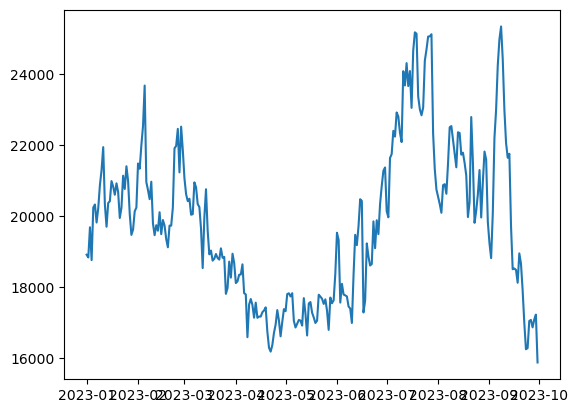

,Date,day_ahead_thermal_power_capacity
0,2023-01-01,18911.3125
1,2023-01-02,18834.662109
2,2023-01-03,19683.544922
3,2023-01-04,18760.207031
4,2023-01-05,20238.894531
...,...,...
268,2023-09-26,17076.164062
269,2023-09-27,16867.474609
270,2023-09-28,17086.207031
271,2023-09-29,17226.408203


In [55]:
# # df4pred

# def get_x_and_y(tgt_day):
#     dminus1 = tgt_day - datetime.timedelta(1)
#     dplus1 = tgt_day + datetime.timedelta(1)
#     x = []
#     gap = []
#     trend = []
#     for _ in pd.date_range(tgt_day - datetime.timedelta(9),tgt_day - datetime.timedelta(2)):
#         trend.append(int(df_capa[df_capa['Date'] == _]['Total Available Capacity']))
#     trend = pd.Series(trend).rolling(5,min_periods=1,center=True).mean().tolist()
#     trend = [trend[-5], trend[-3], trend[-1]]
#     x += trend
#     tmp = df_load_pred_D1[df_load_pred_D1['Date'] == tgt_day]['Load(MW)']
#     tmp1 = df_load_pred_D2[df_load_pred_D2['Date'] == dplus1]['Load(MW)']
#     tmp2 = df_real_load[df_real_load['Date'] == dminus1]['Day-Ahead Cleared Demand']
#     gap += [tmp.min(), tmp.max(), tmp.mean()]
#     gap += [tmp1.min(), tmp1.max(), tmp1.mean()]
#     gap += [tmp2.min(), tmp2.max(), tmp2.mean()]

#     x.append(int(df_capa[df_capa['Date'] == dminus1]['Total Available Capacity']))
    
#     y = int(df_capa[df_capa['Date'] == tgt_day]['Total Available Capacity'])
#     gap = pd.DataFrame(gap).fillna(method = 'bfill')
#     x = x + gap[0].tolist()
#     return x, y
# def pred_tgt_day_capa(tgt_day):
#     # train with date_range 100
#     X, Y = [], []
#     for _ in pd.date_range(tgt_day - datetime.timedelta(100),tgt_day - datetime.timedelta(2)):
#         x, y = get_x_and_y(_)
#         if (not np.isnan(x).any()) and (not np.isnan(y)):
#             X.append(x)
#             Y.append(y)
#     X = np.array(X)
#     Y = np.array(Y)
# #     print(X, Y)
#     model = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=160, silent=True, objective='reg:gamma')
#     model.fit(X,Y)
#     # train with date_range 30
#     X, Y = [], []
#     for _ in pd.date_range(tgt_day - datetime.timedelta(30),tgt_day - datetime.timedelta(2)):
#         x, y = get_x_and_y(_)
#         if (not np.isnan(x).any()) and (not np.isnan(y)):
#             X.append(x)
#             Y.append(y)
#     X = np.array(X)
#     Y = np.array(Y)
#     # print(X.shape, Y.shape)
#     model1 = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=160, silent=True, objective='reg:gamma')
#     model1.fit(X,Y)
#     dminus1 = tgt_day - datetime.timedelta(1)
#     dplus1 = tgt_day + datetime.timedelta(1)
#     x = []
#     gap = []
#     trend = []
#     for _ in pd.date_range(tgt_day - datetime.timedelta(9),tgt_day - datetime.timedelta(2)):
#         trend.append(int(df_capa[df_capa['Date'] == _]['Total Available Capacity']))
#     trend = pd.Series(trend).rolling(5,min_periods=1,center=True).mean().tolist()
#     trend = [trend[-5], trend[-3], trend[-1]]
#     x += trend
#     tmp = df_load_pred_D1[df_load_pred_D1['Date'] == tgt_day]['Load(MW)']
#     tmp1 = df_load_pred_D2[df_load_pred_D2['Date'] == dplus1]['Load(MW)']
#     tmp2 = df_real_load[df_real_load['Date'] == dminus1]['Day-Ahead Cleared Demand']
#     gap += [tmp.min(), tmp.max(), tmp.mean()]
#     gap += [tmp1.min(), tmp1.max(), tmp1.mean()]
#     gap += [tmp2.min(), tmp2.max(), tmp2.mean()]

#     x.append(int(df_capa[df_capa['Date'] == dminus1]['Total Available Capacity']))
#     gap = pd.DataFrame(gap).fillna(method = 'bfill')
#     x = x + gap[0].tolist()
#     if (not np.isnan(x).any()):
#         y_pred = (model.predict(np.array(x).reshape(1,-1)) + model1.predict(np.array(x).reshape(1,-1))) / 2
#         return x, y_pred
#     else:
#         return [], 0
# pred = []
# x_label = []
# xgb.set_config(verbosity=0)
# for _ in pd.date_range(pd.to_datetime('2023/1/1'), pd.to_datetime('2023/9/30')):
#     x, y_pred = pred_tgt_day_capa(_)
#     if y_pred != 0:
#         pred.append(float(y_pred))
#         x_label.append(_)
# plt.plot(x_label, pred)
# plt.show()
# def date2number(date):
#     return int(date.strftime('%Y%m%d'))
# df4pred = pd.DataFrame([x_label, pred]).T
# df4pred.columns = ['Date', 'day_ahead_thermal_power_capacity']
# df4pred['Date'] = pd.to_datetime(df4pred['Date'])
# df4pred

In [43]:
# sarima df4pred1
def pred_by_arima2(tgt_day):
    year_before = df_capa[(tgt_day - datetime.timedelta(395)<df_capa['Date'])*(tgt_day - datetime.timedelta(360)>df_capa['Date'])].reset_index(drop=True)
    # delta = df[tgt_day - datetime.timedelta(361)==df['date_time']]['day_ahead_thermal_power_capacity'] - df[tgt_day - datetime.timedelta(30)==df['date_time']]['day_ahead_thermal_power_capacity']
    # year_before['day_ahead_thermal_power_capacity'] = year_before['day_ahead_thermal_power_capacity'] - delta
    train = df_capa[(tgt_day - datetime.timedelta(30)<df_capa['Date'])*(tgt_day - datetime.timedelta(1)>df_capa['Date'])].reset_index(drop=True)
    train = pd.concat([year_before, train], axis=0, ignore_index=True).reset_index(drop=True)
    # print(train)
    model = SARIMAX(train['Total Available Capacity'], order=(1,0,1), seasonal_order=(1,1,1,34))
    try:
        arima_res=model.fit()
    except:
        return 0
    arima_res.summary()
    predict=arima_res.predict(63)
    # print(predict.values)
    return predict.values
pred = []
x_label = []
xgb.set_config(verbosity=0)
today = datetime.date.today()
for _ in pd.date_range(pd.to_datetime('2023/1/1'), pd.to_datetime('2023/9/30')):
    y_pred = pred_by_arima2(_)
    
    if 0 < y_pred < 100000:
        pred.append(int(y_pred))
        x_label.append(_)

def date2number(date):
    return int(date.strftime('%Y%m%d'))
df4pred1 = pd.DataFrame([x_label, pred]).T
df4pred1.columns = ['Date', 'day_ahead_thermal_power_capacity']
df4pred1['Date'] = pd.to_datetime(df4pred1['Date'])
df4pred1

d:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
d:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
d:\anaconda\Lib\site-packages\statsmodels\tools\eval_measures.py:415: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + np.log(nobs) * df_modelwc
d:\anaconda\Lib\site-packages\statsmodels\tools\eval_measures.py:440: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
d:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3015: RuntimeWarning: 

,Date,day_ahead_thermal_power_capacity
0,2023-01-01,21565
1,2023-01-02,21565
2,2023-01-04,20269
3,2023-01-05,18201
4,2023-01-06,19904
...,...,...
267,2023-09-26,17532
268,2023-09-27,17731
269,2023-09-28,17574
270,2023-09-29,16608


In [47]:
df4pred1.to_csv(r'E:\day-ahead price\Code\Time-Series-Library-main\Results\iso capacity\sarimapred.csv', index=False)

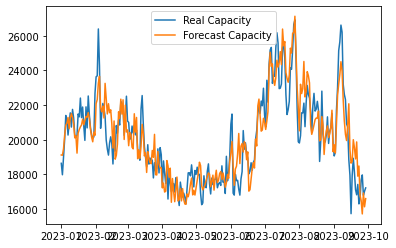

(1227436.209226128, 1107.897201560744, 861.2795589671415, 0.042551329588485926)

In [24]:
df_tmp = pd.merge(df_capa, df4pred, on=['Date'], how='inner')
plt.plot(df_tmp['Date'], df_tmp['Total Available Capacity'], label='Real Capacity')
plt.plot(df_tmp['Date'], df_tmp['day_ahead_thermal_power_capacity'], label='Forecast Capacity')
plt.legend()
plt.show()
loss(df_tmp['Total Available Capacity'].values, df_tmp['day_ahead_thermal_power_capacity'].values)

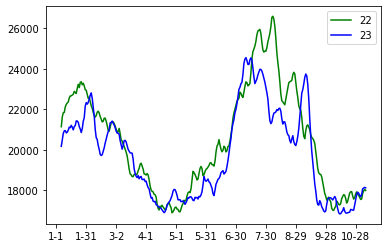

In [9]:
df_capa1 = df_capa.copy()
df_capa1['year'] = df_capa1['Date'].dt.year
df_capa1['month'] = df_capa1['Date'].dt.month
df_capa1['day'] = df_capa1['Date'].dt.day
df_capa1['month_day'] = df_capa1['month'].astype(str) + '-' + df_capa1['day'].astype(str)
groups = dict(list(df_capa1.groupby('year')))
df_capa1 = pd.merge(groups[2022], groups[2023], on='month_day', how='inner')
df_capa1['Total Available Capacity_x'] = df_capa1['Total Available Capacity_x'].rolling(window=10, center=True).mean()
df_capa1['Total Available Capacity_y'] = df_capa1['Total Available Capacity_y'].rolling(window=10, center=True).mean()

# ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10))  # 解决X轴密集问题

plt.plot(df_capa1['month_day'], df_capa1['Total Available Capacity_x'], color='green', label='22')
plt.plot(df_capa1['month_day'], df_capa1['Total Available Capacity_y'], color='blue', label='23')
plt.xticks(df_capa1['month_day'][::30], list(df_capa1['month_day'])[::30])
plt.legend()
plt.show()
# plt.plot(df_capa['Date'], df_capa['Total Available Capacity'], label='Real Capacity')

plt.show()

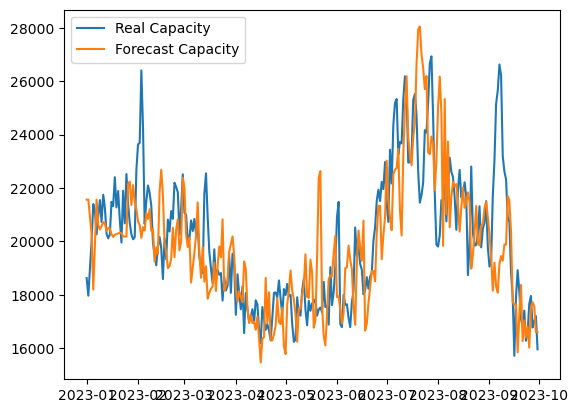

(4122582.7022058824,
 2030.4144163706783,
 1450.8051470588234,
 0.07058483248162332)

In [44]:
df_tmp = pd.merge(df_capa, df4pred1, on=['Date'], how='inner')
plt.plot(df_tmp['Date'], df_tmp['Total Available Capacity'], label='Real Capacity')
plt.plot(df_tmp['Date'], df_tmp['day_ahead_thermal_power_capacity'], label='Forecast Capacity')
plt.legend()
plt.show()
loss(df_tmp['Total Available Capacity'].values, df_tmp['day_ahead_thermal_power_capacity'].values)

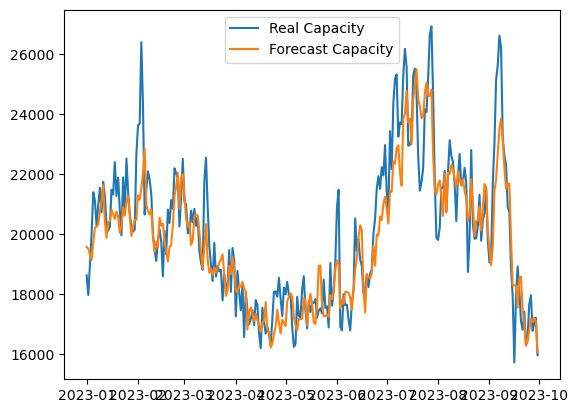

(1210293.3853646398, 1100.133348901232, 806.1778690113741, 0.03924160653723544)

In [57]:
df_capa_pred_esmb = pd.merge(df4pred, df4pred1, on=['Date'], how='inner')
df_capa_pred_esmb['day_ahead_thermal_power_capacity'] = (3 * df_capa_pred_esmb['day_ahead_thermal_power_capacity_x'] + df_capa_pred_esmb['day_ahead_thermal_power_capacity_y']) / 4
df_tmp = pd.merge(df_capa, df_capa_pred_esmb, on=['Date'], how='inner')
plt.plot(df_tmp['Date'], df_tmp['Total Available Capacity'], label='Real Capacity')
plt.plot(df_tmp['Date'], df_tmp['day_ahead_thermal_power_capacity'], label='Forecast Capacity')
plt.legend()
plt.show()
loss(df_tmp['Total Available Capacity'].values, df_tmp['day_ahead_thermal_power_capacity'].values)

In [11]:
df_xgbpred = pd.read_csv(r'E:\day-ahead price\Code\Time-Series-Library-main\Results\iso capacity\xgbpred1.csv')
df_sarimapred = pd.read_csv(r'E:\day-ahead price\Code\Time-Series-Library-main\Results\iso capacity\sarimapred.csv')
df_timesnetpred = pd.read_csv(r'E:\day-ahead price\Code\Time-Series-Library-main\Results\iso capacity\capacity_timesnet.csv')
df_xgbpred['Date'] = pd.to_datetime(df_xgbpred['Date'])
df_sarimapred['Date'] = pd.to_datetime(df_sarimapred['Date'])
df_timesnetpred['Date'] = pd.to_datetime(df_timesnetpred['date'])
df_capa_pred_esmb = pd.merge(df_xgbpred, df_sarimapred, on=['Date'], how='inner')
df_capa_pred_esmb = pd.merge(df_capa_pred_esmb, df_timesnetpred, on=['Date'], how='inner')
pred_by_xgb_sarima = 0.9 * df_capa_pred_esmb['day_ahead_thermal_power_capacity_x'] + 0.1 * df_capa_pred_esmb['day_ahead_thermal_power_capacity_y']
pred_by_xgb_timesnet = 0.9 * df_capa_pred_esmb['day_ahead_thermal_power_capacity_x'] + 0.1 * df_capa_pred_esmb['pred']
print('xgb loss:', loss(df_capa_pred_esmb['day_ahead_thermal_power_capacity_x'].values, df_capa_pred_esmb['true'].values))
print('sarima loss:', loss(df_capa_pred_esmb['day_ahead_thermal_power_capacity_y'].values, df_capa_pred_esmb['true'].values))
print('timesnet loss:', loss(df_capa_pred_esmb['pred'].values, df_capa_pred_esmb['true'].values))
print('xgb_sarima loss:', loss(pred_by_xgb_sarima.values, df_capa_pred_esmb['true'].values))
print('xgb_timesnet loss:', loss(pred_by_xgb_timesnet.values, df_capa_pred_esmb['true'].values))

xgb loss: (767445.3759360999, 876.0395972420995, 680.1845883302583, 0.033720902739731995)
sarima loss: (4136293.177121771, 2033.787888921008, 1453.8044280442805, 0.07070070132700254)
timesnet loss: (2347614.648719543, 1532.192758343265, 1182.2840738007378, 0.057556833794382416)
xgb_sarima loss: (782391.4707699887, 884.5289541727782, 683.3789970595018, 0.03374395494674874)
xgb_timesnet loss: (745356.0263472762, 863.3400409730086, 675.2609849688653, 0.03344988308293271)


In [39]:
df_save = df_capa[['Date', 'Total Available Capacity']]
df_save.to_csv(r'E:\day-ahead price\Code\Time-Series-Library-main\Time-Series-Library-main\data\iso_capacity_only.csv', index=False)
df_save

,Date,Total Available Capacity
0,2022-01-01,19171.0
1,2022-01-02,19255.0
2,2022-01-03,21433.0
3,2022-01-04,21112.0
4,2022-01-05,21720.0
...,...,...
675,2023-11-07,18353.0
676,2023-11-08,19796.0
677,2023-11-09,18721.0
678,2023-11-10,18325.0


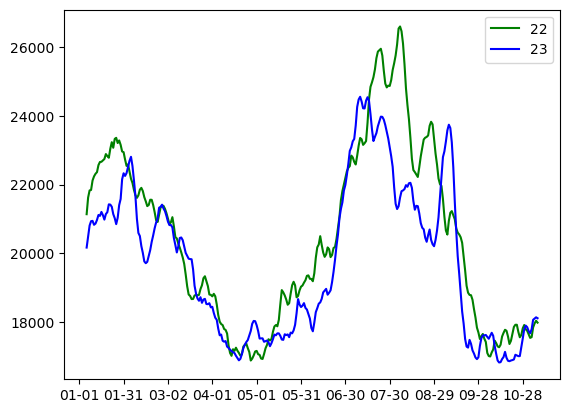

In [45]:
df_capa1 = df_capa
df_capa1['Date'] = pd.to_datetime(df_capa1['Date'])
df_capa1['year'] = df_capa1['Date'].dt.year
df_capa1['month'] = df_capa1['Date'].dt.month
df_capa1['day'] = df_capa1['Date'].dt.day
df_capa1['month'] = df_capa1['month'].astype(str).str.zfill(2)
df_capa1['day'] = df_capa1['day'].astype(str).str.zfill(2)
df_capa1['month_day'] = df_capa1['month'] + '-' + df_capa1['day']
groups = dict(list(df_capa1.groupby('year')))
df_capa1 = pd.merge(groups[2022], groups[2023], on='month_day', how='inner')
df_capa1['Total Available Capacity_x'] = df_capa1['Total Available Capacity_x'].rolling(window=10, center=True).mean()
df_capa1['Total Available Capacity_y'] = df_capa1['Total Available Capacity_y'].rolling(window=10, center=True).mean()

# ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10))  # 解决X轴密集问题

plt.plot(df_capa1['month_day'], df_capa1['Total Available Capacity_x'], color='green', label='22')
plt.plot(df_capa1['month_day'], df_capa1['Total Available Capacity_y'], color='blue', label='23')
plt.xticks(df_capa1['month_day'][::30], list(df_capa1['month_day'])[::30])
plt.legend()
plt.show()

In [ ]:
df_capa['Surplus Deficiency'].describe()

count     407.000000
mean     1886.496314
std       770.677333
min       197.000000
25%      1331.500000
50%      1895.000000
75%      2423.500000
max      4429.000000
Name: Surplus Deficiency, dtype: float64

In [21]:
df_capa_pred_D1['Projected Surplus/(Deficiency)'].astype(float).describe()

count      405.000000
mean      9935.765432
std       2842.186389
min       3946.000000
25%       7591.000000
50%      10076.000000
75%      12441.000000
max      15521.000000
Name: Projected Surplus/(Deficiency), dtype: float64

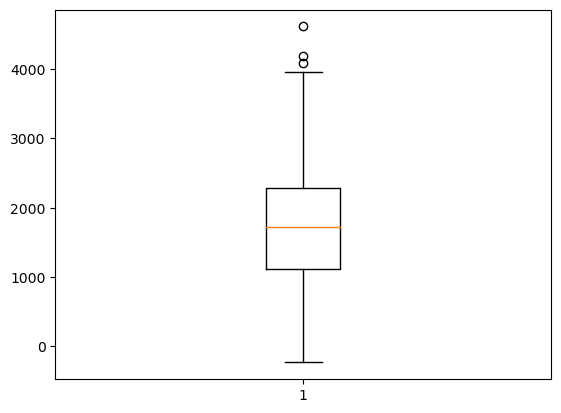

count     404.000000
mean     1709.311881
std       828.283179
min      -236.000000
25%      1115.750000
50%      1720.000000
75%      2290.500000
max      4618.000000
Name: delta, dtype: float64

In [31]:
df_tmp = pd.merge(df_capa, df_capa_pred_D1, on=['Date'], how='inner')
df_tmp['delta'] = df_tmp['Total Available Capacity'] - df_tmp['Total Load plus Required Reserve']
plt.boxplot(df_tmp['delta'])
plt.show()
df_tmp['delta'].astype(float).describe()

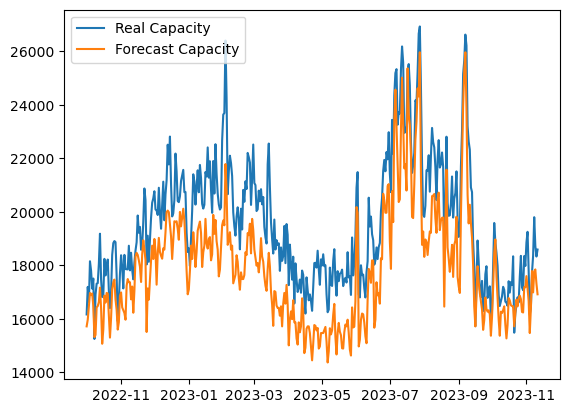

(3606101.9801980196,
 1898.9739282565256,
 1713.7722772277227,
 0.09148632628244828)

In [35]:
plt.plot(df_tmp['Date'], df_tmp['Total Available Capacity'], label='Real Capacity')
plt.plot(df_tmp['Date'], df_tmp['Total Load plus Required Reserve'], label='Forecast Capacity')
plt.legend()
plt.show()
loss(df_tmp['Total Available Capacity'].values, df_tmp['Total Load plus Required Reserve'].values)

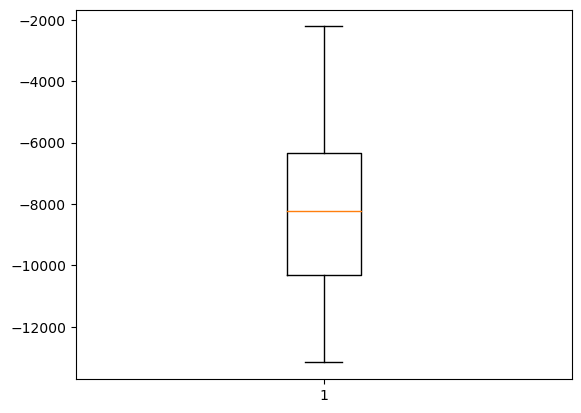

count      404.000000
mean     -8234.740099
std       2546.323042
min     -13162.000000
25%     -10311.750000
50%      -8226.000000
75%      -6335.000000
max      -2221.000000
Name: delta, dtype: float64

In [38]:
df_tmp = pd.merge(df_capa, df_capa_pred_D1, on=['Date'], how='inner')
df_tmp['delta'] = df_tmp['Total Available Capacity'] - df_tmp['Total Available Generation and Imports']
plt.boxplot(df_tmp['delta'])
plt.show()
df_tmp['delta'].astype(float).describe()

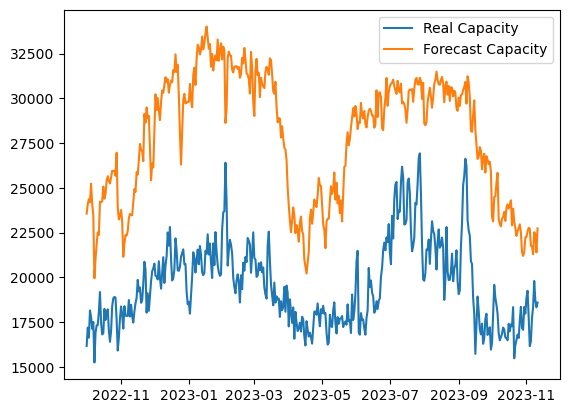

(74278656.62128712, 8618.506635217445, 8234.740099009901, 0.34547607698467675)

In [40]:
plt.plot(df_tmp['Date'], df_tmp['Total Available Capacity'], label='Real Capacity')
plt.plot(df_tmp['Date'], df_tmp['Total Available Generation and Imports'], label='Forecast Capacity')
plt.legend()
plt.show()
loss(df_tmp['Total Available Capacity'].values, df_tmp['Total Available Generation and Imports'].values)

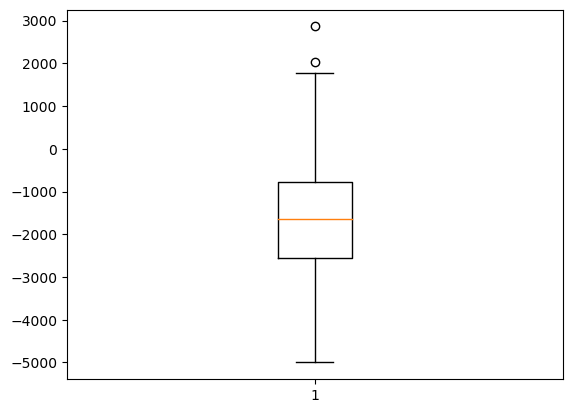

count     404.000000
mean    -1611.099010
std      1304.658148
min     -5001.000000
25%     -2564.500000
50%     -1649.500000
75%      -770.750000
max      2864.000000
Name: delta, dtype: float64

In [29]:
df_tmp = pd.merge(df_capa, df_capa_pred_D1, on=['Date'], how='inner')
df_tmp['delta'] = df_tmp['Uncommitted Available Generation'] - df_tmp['Projected Surplus/(Deficiency)']
plt.boxplot(df_tmp['delta'])
plt.show()
df_tmp['delta'].astype(float).describe()

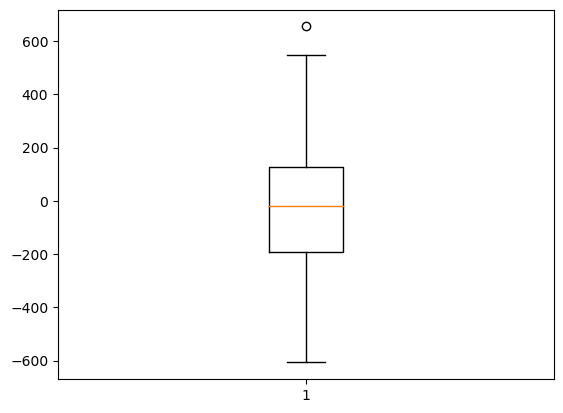

count    404.000000
mean     -16.353960
std      208.248101
min     -607.000000
25%     -192.000000
50%      -18.000000
75%      127.250000
max      655.000000
Name: delta, dtype: float64

In [36]:
# df_tmp = df_capa['Capacity Required'] - df_capa_pred_D1['Total Load plus Required Reserve']
df_tmp = pd.merge(df_capa, df_capa_pred_D1, on=['Date'], how='inner')
df_tmp['delta'] = df_tmp['Capacity Required'] + df_tmp['Replacement Reserve Requirement_y'] - df_tmp['Total Load plus Required Reserve']
plt.boxplot(df_tmp['delta'])
plt.show()
df_tmp['delta'].astype(float).describe()

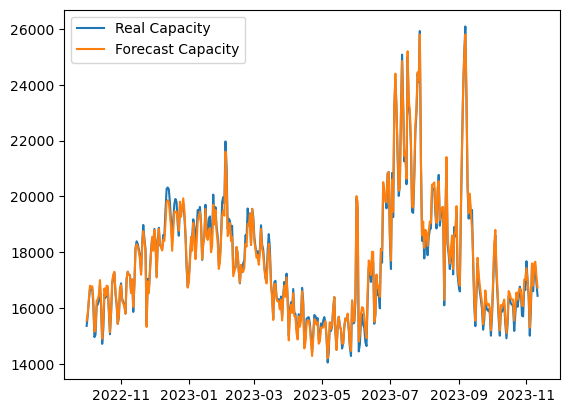

(43527.37871287129,
 208.6321612620434,
 169.98762376237624,
 0.009611895823738585)

In [37]:
plt.plot(df_tmp['Date'], df_tmp['Capacity Required'], label='Real Capacity')
plt.plot(df_tmp['Date'], df_tmp['Total Load plus Required Reserve'] - df_tmp['Replacement Reserve Requirement_y'], label='Forecast Capacity')
plt.legend()
plt.show()
loss(df_tmp['Capacity Required'].values, df_tmp['Total Load plus Required Reserve'].values - df_tmp['Replacement Reserve Requirement_y'].values)


In [25]:
# df4pred

def get_x_and_y(tgt_day):
    dminus1 = tgt_day - datetime.timedelta(1)
    dminus2 = tgt_day - datetime.timedelta(2)
    dminus3 = tgt_day - datetime.timedelta(3)
    dplus1 = tgt_day + datetime.timedelta(1)
    x = []
    # trend = []
    # for _ in pd.date_range(tgt_day - datetime.timedelta(9),tgt_day - datetime.timedelta(2)):
    #     trend.append(int(df_capa[df_capa['Date'] == _]['Total Available Capacity']))
    # trend = pd.Series(trend).rolling(5,min_periods=1,center=True).mean().tolist()
    # trend = [trend[-5], trend[-3], trend[-1]]
    # x += trend
    tmp = df_load_pred_D1[df_load_pred_D1['Date'] == tgt_day]['Load(MW)']
    tmp1 = df_load_pred_D2[df_load_pred_D2['Date'] == dplus1]['Load(MW)']
    tmp2 = df_real_load[df_real_load['Date'] == dminus1]['Day-Ahead Cleared Demand']
    tmp3 = df_real_load[df_real_load['Date'] == dminus2]['Day-Ahead Cleared Demand']
    tmp4 = df_real_load[df_real_load['Date'] == dminus3]['Day-Ahead Cleared Demand']
    gap = [tmp.min(), tmp.max(), tmp.mean()]
    gap1 = [tmp1.min(), tmp1.max(), tmp1.mean()]
    gap2 = [tmp2.min(), tmp2.max(), tmp2.mean()]
    gap3 = [tmp3.min(), tmp3.max(), tmp3.mean()]
    gap4 = [tmp4.min(), tmp4.max(), tmp4.mean()]
    gap = pd.DataFrame(gap).fillna(method = 'bfill')[0].tolist()
    gap1 = pd.DataFrame(gap1).fillna(method = 'bfill')[0].tolist()
    gap2 = pd.DataFrame(gap2).fillna(method = 'bfill')[0].tolist()
    gap3 = pd.DataFrame(gap3).fillna(method = 'bfill')[0].tolist()
    gap4 = pd.DataFrame(gap4).fillna(method = 'bfill')[0].tolist()
    x += np.subtract(gap, gap2).tolist()
    x += np.subtract(gap, gap3).tolist()
    x += np.subtract(gap, gap4).tolist()
    if len(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Hartford']) != 0:
        temp_b, temp_h = float(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Hartford'])
    else:
        temp_b, temp_h = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus1]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus1]['Hartford']) != 0:
        temp_b1, temp_h1 = float(df_temp_pred[df_temp_pred['Date'] == dminus1]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus1]['Hartford'])
    else:
        temp_b1, temp_h1 = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus2]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus2]['Hartford']) != 0:
        temp_b2, temp_h2 = float(df_temp_pred[df_temp_pred['Date'] == dminus2]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus2]['Hartford'])
    else:
        temp_b2, temp_h2 = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus3]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus3]['Hartford']) != 0:
        temp_b3, temp_h3 = float(df_temp_pred[df_temp_pred['Date'] == dminus3]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus3]['Hartford'])
    else:
        temp_b3, temp_h3 = 0, 0
    x += [temp_b - temp_b1, temp_h - temp_h1]
    x += [temp_b - temp_b2, temp_h - temp_h2]
    x += [temp_b - temp_b3, temp_h - temp_h3]
    x.append(int(df_capa[df_capa['Date'] == dminus1]['Total Available Capacity']))
    x.append(int(df_capa[df_capa['Date'] == dminus2]['Total Available Capacity']))
    x.append(int(df_capa[df_capa['Date'] == dminus3]['Total Available Capacity']))
    if len(df_timesnetpred[df_timesnetpred['Date'] == tgt_day]['pred']) != 0:
        x += [float(df_timesnetpred[df_timesnetpred['Date'] == tgt_day]['pred'])]
    
    y = int(df_capa[df_capa['Date'] == tgt_day]['Total Available Capacity']) - int(df_capa[df_capa['Date'] == dminus1]['Total Available Capacity'])

    return x, y
def pred_tgt_day_capa(tgt_day):
    # train with date_range 100
    X, Y = [], []
    for _ in pd.date_range(tgt_day - datetime.timedelta(100),tgt_day - datetime.timedelta(2)):
        x, y = get_x_and_y(_)
        # print(x, y)
        if (not np.isnan(x).any()) and (not np.isnan(y)):
            X.append(x)
            Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
#     print(X, Y)
    model = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=160, silent=True)
    # model = xgb.XGBRegressor()
    model.fit(X,Y)
    # train with date_range 30
    X, Y = [], []
    for _ in pd.date_range(tgt_day - datetime.timedelta(30),tgt_day - datetime.timedelta(2)):
        x, y = get_x_and_y(_)
        # print(x, y)
        if (not np.isnan(x).any()) and (not np.isnan(y)):
            X.append(x)
            Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    # print(X.shape, Y.shape)
    model1 = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=160, silent=True)
    model1.fit(X,Y)
    dminus1 = tgt_day - datetime.timedelta(1)
    dminus2 = tgt_day - datetime.timedelta(2)
    dminus3 = tgt_day - datetime.timedelta(3)
    dplus1 = tgt_day + datetime.timedelta(1)
    x = []
    gap = []
    # trend = []
    # for _ in pd.date_range(tgt_day - datetime.timedelta(9),tgt_day - datetime.timedelta(2)):
    #     trend.append(int(df_capa[df_capa['Date'] == _]['Total Available Capacity']))
    # trend = pd.Series(trend).rolling(5,min_periods=1,center=True).mean().tolist()
    # trend = [trend[-5], trend[-3], trend[-1]]
    # x += trend
    tmp = df_load_pred_D1[df_load_pred_D1['Date'] == tgt_day]['Load(MW)']
    tmp1 = df_load_pred_D2[df_load_pred_D2['Date'] == dplus1]['Load(MW)']
    tmp2 = df_real_load[df_real_load['Date'] == dminus1]['Day-Ahead Cleared Demand']
    tmp3 = df_real_load[df_real_load['Date'] == dminus2]['Day-Ahead Cleared Demand']
    tmp4 = df_real_load[df_real_load['Date'] == dminus3]['Day-Ahead Cleared Demand']
    gap = [tmp.min(), tmp.max(), tmp.mean()]
    gap1 = [tmp1.min(), tmp1.max(), tmp1.mean()]
    gap2 = [tmp2.min(), tmp2.max(), tmp2.mean()]
    gap3 = [tmp3.min(), tmp3.max(), tmp3.mean()]
    gap4 = [tmp4.min(), tmp4.max(), tmp4.mean()]
    gap = pd.DataFrame(gap).fillna(method = 'bfill')[0].tolist()
    gap1 = pd.DataFrame(gap1).fillna(method = 'bfill')[0].tolist()
    gap2 = pd.DataFrame(gap2).fillna(method = 'bfill')[0].tolist()
    gap3 = pd.DataFrame(gap3).fillna(method = 'bfill')[0].tolist()
    gap4 = pd.DataFrame(gap4).fillna(method = 'bfill')[0].tolist()
    x += np.subtract(gap, gap2).tolist()
    x += np.subtract(gap, gap3).tolist()
    x += np.subtract(gap, gap4).tolist()
    if len(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Hartford']) != 0:
        temp_b, temp_h = float(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Hartford'])
    else:
        temp_b, temp_h = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus1]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus1]['Hartford']) != 0:
        temp_b1, temp_h1 = float(df_temp_pred[df_temp_pred['Date'] == dminus1]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus1]['Hartford'])
    else:
        temp_b1, temp_h1 = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus2]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus2]['Hartford']) != 0:
        temp_b2, temp_h2 = float(df_temp_pred[df_temp_pred['Date'] == dminus2]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus2]['Hartford'])
    else:
        temp_b2, temp_h2 = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus3]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus3]['Hartford']) != 0:
        temp_b3, temp_h3 = float(df_temp_pred[df_temp_pred['Date'] == dminus3]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus3]['Hartford'])
    else:
        temp_b3, temp_h3 = 0, 0

    x += [temp_b - temp_b1, temp_h - temp_h1]
    x += [temp_b - temp_b2, temp_h - temp_h2]
    x += [temp_b - temp_b3, temp_h - temp_h3]
    x.append(int(df_capa[df_capa['Date'] == dminus1]['Total Available Capacity']))
    x.append(int(df_capa[df_capa['Date'] == dminus2]['Total Available Capacity']))
    x.append(int(df_capa[df_capa['Date'] == dminus3]['Total Available Capacity']))
    if len(df_timesnetpred[df_timesnetpred['Date'] == tgt_day]['pred']) != 0:
        x += [float(df_timesnetpred[df_timesnetpred['Date'] == tgt_day]['pred'])]
    
    if (not np.isnan(x).any()):
        y_pred = (model.predict(np.array(x).reshape(1,-1)) + model1.predict(np.array(x).reshape(1,-1))) / 2
        return x, y_pred + int(df_capa[df_capa['Date'] == dminus1]['Total Available Capacity'])
    else:
        return [], 0
pred = []
x_label = []
xgb.set_config(verbosity=0)
for _ in pd.date_range(pd.to_datetime('2023/1/1'), pd.to_datetime('2023/9/30')):
    x, y_pred = pred_tgt_day_capa(_)
    if y_pred != 0:
        pred.append(float(y_pred))
        x_label.append(_)
plt.plot(x_label, pred)
plt.show()
def date2number(date):
    return int(date.strftime('%Y%m%d'))
df4pred = pd.DataFrame([x_label, pred]).T
df4pred.columns = ['Date', 'day_ahead_thermal_power_capacity']
df4pred['Date'] = pd.to_datetime(df4pred['Date'])
df4pred

ValueError: Feature shape mismatch, expected: 19, got 18

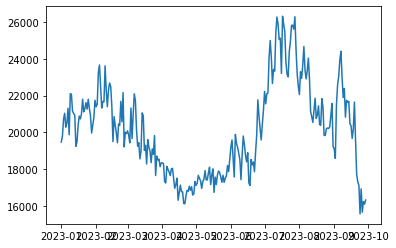

,Date,day_ahead_thermal_power_capacity
0,2023-01-01,19482.419922
1,2023-01-02,19804.076172
2,2023-01-03,20714.900391
3,2023-01-04,21046.066406
4,2023-01-05,20287.060547
...,...,...
267,2023-09-25,16937.220703
268,2023-09-26,15671.78125
269,2023-09-27,16248.441406
270,2023-09-28,16113.082031


In [18]:
# df4pred

def get_x_and_y(tgt_day):
    dminus1 = tgt_day - datetime.timedelta(1)
    dminus2 = tgt_day - datetime.timedelta(2)
    dminus3 = tgt_day - datetime.timedelta(3)
    dplus1 = tgt_day + datetime.timedelta(1)
    x = []
    trend = []
    for _ in pd.date_range(tgt_day - datetime.timedelta(9),tgt_day - datetime.timedelta(2)):
        trend.append(int(df_capa[df_capa['Date'] == _]['Total Available Capacity']))
    trend = pd.Series(trend).rolling(5,min_periods=1,center=True).mean().tolist()
    trend = [trend[-5], trend[-3], trend[-1]]
    x += trend
    tmp = df_load_pred_D1[df_load_pred_D1['Date'] == tgt_day]['Load(MW)']
    tmp1 = df_load_pred_D2[df_load_pred_D2['Date'] == dplus1]['Load(MW)']
    tmp2 = df_real_load[df_real_load['Date'] == dminus1]['Day-Ahead Cleared Demand']
    tmp3 = df_real_load[df_real_load['Date'] == dminus2]['Day-Ahead Cleared Demand']
    tmp4 = df_real_load[df_real_load['Date'] == dminus3]['Day-Ahead Cleared Demand']
    gap = [tmp.min(), tmp.max(), tmp.mean()]
    gap1 = [tmp1.min(), tmp1.max(), tmp1.mean()]
    gap2 = [tmp2.min(), tmp2.max(), tmp2.mean()]
    gap3 = [tmp3.min(), tmp3.max(), tmp3.mean()]
    gap4 = [tmp4.min(), tmp4.max(), tmp4.mean()]
    gap = pd.DataFrame(gap).fillna(method = 'bfill')[0].tolist()
    gap1 = pd.DataFrame(gap1).fillna(method = 'bfill')[0].tolist()
    gap2 = pd.DataFrame(gap2).fillna(method = 'bfill')[0].tolist()
    gap3 = pd.DataFrame(gap3).fillna(method = 'bfill')[0].tolist()
    gap4 = pd.DataFrame(gap4).fillna(method = 'bfill')[0].tolist()
    x += np.subtract(gap, gap2).tolist()
    x += np.subtract(gap, gap3).tolist()
    x += np.subtract(gap, gap4).tolist()
    if len(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Hartford']) != 0:
        temp_b, temp_h = float(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Hartford'])
    else:
        temp_b, temp_h = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus1]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus1]['Hartford']) != 0:
        temp_b1, temp_h1 = float(df_temp_pred[df_temp_pred['Date'] == dminus1]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus1]['Hartford'])
    else:
        temp_b1, temp_h1 = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus2]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus2]['Hartford']) != 0:
        temp_b2, temp_h2 = float(df_temp_pred[df_temp_pred['Date'] == dminus2]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus2]['Hartford'])
    else:
        temp_b2, temp_h2 = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus3]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus3]['Hartford']) != 0:
        temp_b3, temp_h3 = float(df_temp_pred[df_temp_pred['Date'] == dminus3]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus3]['Hartford'])
    else:
        temp_b3, temp_h3 = 0, 0
    x += [temp_b - temp_b1, temp_h - temp_h1]
    x += [temp_b - temp_b2, temp_h - temp_h2]
    x += [temp_b - temp_b3, temp_h - temp_h3]
    x.append(int(df_capa[df_capa['Date'] == dminus1]['Total Available Capacity']))
    x.append(int(df_capa[df_capa['Date'] == dminus2]['Total Available Capacity']))
    x.append(int(df_capa[df_capa['Date'] == dminus3]['Total Available Capacity']))
    if len(df_timesnetpred[df_timesnetpred['Date'] == tgt_day]['pred']) != 0:    
        y = int(df_capa[df_capa['Date'] == tgt_day]['Total Available Capacity']) - float(df_timesnetpred[df_timesnetpred['Date'] == tgt_day]['pred'])
        return x, y
    else:
        return [], np.nan
def pred_tgt_day_capa(tgt_day):
    # train with date_range 100
    X, Y = [], []
    for _ in pd.date_range(tgt_day - datetime.timedelta(100),tgt_day - datetime.timedelta(2)):
        x, y = get_x_and_y(_)
        # print(x, y)
        if (not np.isnan(x).any()) and (not np.isnan(y)):
            X.append(x)
            Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
#     print(X, Y)
    # model = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=160, silent=True)
    model = xgb.XGBRegressor()
    model.fit(X,Y)
    # train with date_range 30
    X, Y = [], []
    for _ in pd.date_range(tgt_day - datetime.timedelta(30),tgt_day - datetime.timedelta(2)):
        x, y = get_x_and_y(_)
        # print(x, y)
        if (not np.isnan(x).any()) and (not np.isnan(y)):
            X.append(x)
            Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    # print(X.shape, Y.shape)
    model1 = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=160, silent=True)
    model1.fit(X,Y)
    dminus1 = tgt_day - datetime.timedelta(1)
    dminus2 = tgt_day - datetime.timedelta(2)
    dminus3 = tgt_day - datetime.timedelta(3)
    dplus1 = tgt_day + datetime.timedelta(1)
    x = []
    gap = []
    trend = []
    for _ in pd.date_range(tgt_day - datetime.timedelta(9),tgt_day - datetime.timedelta(2)):
        trend.append(int(df_capa[df_capa['Date'] == _]['Total Available Capacity']))
    trend = pd.Series(trend).rolling(5,min_periods=1,center=True).mean().tolist()
    trend = [trend[-5], trend[-3], trend[-1]]
    x += trend
    tmp = df_load_pred_D1[df_load_pred_D1['Date'] == tgt_day]['Load(MW)']
    tmp1 = df_load_pred_D2[df_load_pred_D2['Date'] == dplus1]['Load(MW)']
    tmp2 = df_real_load[df_real_load['Date'] == dminus1]['Day-Ahead Cleared Demand']
    tmp3 = df_real_load[df_real_load['Date'] == dminus2]['Day-Ahead Cleared Demand']
    tmp4 = df_real_load[df_real_load['Date'] == dminus3]['Day-Ahead Cleared Demand']
    gap = [tmp.min(), tmp.max(), tmp.mean()]
    gap1 = [tmp1.min(), tmp1.max(), tmp1.mean()]
    gap2 = [tmp2.min(), tmp2.max(), tmp2.mean()]
    gap3 = [tmp3.min(), tmp3.max(), tmp3.mean()]
    gap4 = [tmp4.min(), tmp4.max(), tmp4.mean()]
    gap = pd.DataFrame(gap).fillna(method = 'bfill')[0].tolist()
    gap1 = pd.DataFrame(gap1).fillna(method = 'bfill')[0].tolist()
    gap2 = pd.DataFrame(gap2).fillna(method = 'bfill')[0].tolist()
    gap3 = pd.DataFrame(gap3).fillna(method = 'bfill')[0].tolist()
    gap4 = pd.DataFrame(gap4).fillna(method = 'bfill')[0].tolist()
    x += np.subtract(gap, gap2).tolist()
    x += np.subtract(gap, gap3).tolist()
    x += np.subtract(gap, gap4).tolist()
    if len(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Hartford']) != 0:
        temp_b, temp_h = float(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Hartford'])
    else:
        temp_b, temp_h = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus1]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus1]['Hartford']) != 0:
        temp_b1, temp_h1 = float(df_temp_pred[df_temp_pred['Date'] == dminus1]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus1]['Hartford'])
    else:
        temp_b1, temp_h1 = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus2]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus2]['Hartford']) != 0:
        temp_b2, temp_h2 = float(df_temp_pred[df_temp_pred['Date'] == dminus2]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus2]['Hartford'])
    else:
        temp_b2, temp_h2 = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus3]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus3]['Hartford']) != 0:
        temp_b3, temp_h3 = float(df_temp_pred[df_temp_pred['Date'] == dminus3]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus3]['Hartford'])
    else:
        temp_b3, temp_h3 = 0, 0

    x += [temp_b - temp_b1, temp_h - temp_h1]
    x += [temp_b - temp_b2, temp_h - temp_h2]
    x += [temp_b - temp_b3, temp_h - temp_h3]
    x.append(int(df_capa[df_capa['Date'] == dminus1]['Total Available Capacity']))
    x.append(int(df_capa[df_capa['Date'] == dminus2]['Total Available Capacity']))
    x.append(int(df_capa[df_capa['Date'] == dminus3]['Total Available Capacity']))
    
    if (not np.isnan(x).any()) and (len(df_timesnetpred[df_timesnetpred['Date'] == tgt_day]['pred']) != 0):
        y_pred = (model.predict(np.array(x).reshape(1,-1)) + model1.predict(np.array(x).reshape(1,-1))) / 2
        return x, y_pred + float(df_timesnetpred[df_timesnetpred['Date'] == tgt_day]['pred'])
    else:
        return [], 0
pred = []
x_label = []
xgb.set_config(verbosity=0)
for _ in pd.date_range(pd.to_datetime('2023/1/1'), pd.to_datetime('2023/9/30')):
    x, y_pred = pred_tgt_day_capa(_)
    if y_pred != 0:
        pred.append(float(y_pred))
        x_label.append(_)
plt.plot(x_label, pred)
plt.show()
def date2number(date):
    return int(date.strftime('%Y%m%d'))
df4pred = pd.DataFrame([x_label, pred]).T
df4pred.columns = ['Date', 'day_ahead_thermal_power_capacity']
df4pred['Date'] = pd.to_datetime(df4pred['Date'])
df4pred

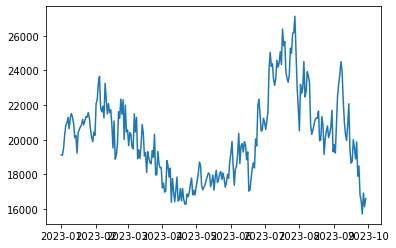

,Date,day_ahead_thermal_power_capacity
0,2023-01-01,19115.203125
1,2023-01-02,19099.785156
2,2023-01-03,19481.121094
3,2023-01-04,20265.677734
4,2023-01-05,20829.748047
...,...,...
267,2023-09-25,16469.507812
268,2023-09-26,15707.408203
269,2023-09-27,16917.322266
270,2023-09-28,16118.457031


In [23]:
# df4pred

def get_x_and_y(tgt_day):
    dminus1 = tgt_day - datetime.timedelta(1)
    dminus2 = tgt_day - datetime.timedelta(2)
    dminus3 = tgt_day - datetime.timedelta(3)
    dminus4 = tgt_day - datetime.timedelta(4)
    dminus5 = tgt_day - datetime.timedelta(5)
    dminus6 = tgt_day - datetime.timedelta(6)
    dminus7 = tgt_day - datetime.timedelta(7)
    dplus1 = tgt_day + datetime.timedelta(1)
    x = []
    trend = []
    for _ in pd.date_range(tgt_day - datetime.timedelta(9),tgt_day - datetime.timedelta(2)):
        trend.append(int(df_capa[df_capa['Date'] == _]['Total Available Capacity']))
    trend = pd.Series(trend).rolling(5,min_periods=1,center=True).mean().tolist()
    trend = [trend[-5], trend[-3], trend[-1]]
    x += trend
    tmp = df_load_pred_D1[df_load_pred_D1['Date'] == tgt_day]['Load(MW)']
    tmp1 = df_load_pred_D2[df_load_pred_D2['Date'] == dplus1]['Load(MW)']
    tmp2 = df_real_load[df_real_load['Date'] == dminus1]['Day-Ahead Cleared Demand']
    tmp3 = df_real_load[df_real_load['Date'] == dminus2]['Day-Ahead Cleared Demand']
    tmp4 = df_real_load[df_real_load['Date'] == dminus3]['Day-Ahead Cleared Demand']
    tmp5 = df_real_load[df_real_load['Date'] == dminus4]['Day-Ahead Cleared Demand']
    tmp6 = df_real_load[df_real_load['Date'] == dminus5]['Day-Ahead Cleared Demand']
    tmp7 = df_real_load[df_real_load['Date'] == dminus6]['Day-Ahead Cleared Demand']
    tmp8 = df_real_load[df_real_load['Date'] == dminus7]['Day-Ahead Cleared Demand']
    gap = [tmp.min(), tmp.max(), tmp.mean()]
    gap1 = [tmp1.min(), tmp1.max(), tmp1.mean()]
    gap2 = [tmp2.min(), tmp2.max(), tmp2.mean()]
    gap3 = [tmp3.min(), tmp3.max(), tmp3.mean()]
    gap4 = [tmp4.min(), tmp4.max(), tmp4.mean()]
    gap5 = [tmp5.min(), tmp5.max(), tmp5.mean()]
    gap6 = [tmp6.min(), tmp6.max(), tmp6.mean()]
    gap7 = [tmp7.min(), tmp7.max(), tmp7.mean()]
    gap = pd.DataFrame(gap).fillna(method = 'bfill')[0].tolist()
    gap1 = pd.DataFrame(gap1).fillna(method = 'bfill')[0].tolist()
    gap2 = pd.DataFrame(gap2).fillna(method = 'bfill')[0].tolist()
    gap3 = pd.DataFrame(gap3).fillna(method = 'bfill')[0].tolist()
    gap4 = pd.DataFrame(gap4).fillna(method = 'bfill')[0].tolist()
    gap5 = pd.DataFrame(gap5).fillna(method = 'bfill')[0].tolist()
    gap6 = pd.DataFrame(gap6).fillna(method = 'bfill')[0].tolist()
    gap7 = pd.DataFrame(gap7).fillna(method = 'bfill')[0].tolist()
    x += np.subtract(gap, gap2).tolist()
    x += np.subtract(gap, gap3).tolist()
    x += np.subtract(gap, gap4).tolist()
    x += np.subtract(gap, gap5).tolist()
    x += np.subtract(gap, gap6).tolist()
    x += np.subtract(gap, gap7).tolist()
    if len(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Hartford']) != 0:
        temp_b, temp_h = float(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Hartford'])
    else:
        temp_b, temp_h = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus1]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus1]['Hartford']) != 0:
        temp_b1, temp_h1 = float(df_temp_pred[df_temp_pred['Date'] == dminus1]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus1]['Hartford'])
    else:
        temp_b1, temp_h1 = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus2]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus2]['Hartford']) != 0:
        temp_b2, temp_h2 = float(df_temp_pred[df_temp_pred['Date'] == dminus2]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus2]['Hartford'])
    else:
        temp_b2, temp_h2 = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus3]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus3]['Hartford']) != 0:
        temp_b3, temp_h3 = float(df_temp_pred[df_temp_pred['Date'] == dminus3]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus3]['Hartford'])
    else:
        temp_b3, temp_h3 = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus4]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus4]['Hartford']) != 0:
        temp_b4, temp_h4 = float(df_temp_pred[df_temp_pred['Date'] == dminus4]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus4]['Hartford'])
    else:
        temp_b4, temp_h4 = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus5]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus5]['Hartford']) != 0:
        temp_b5, temp_h5 = float(df_temp_pred[df_temp_pred['Date'] == dminus5]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus5]['Hartford'])
    else:
        temp_b5, temp_h5 = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus6]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus6]['Hartford']) != 0:
        temp_b6, temp_h6 = float(df_temp_pred[df_temp_pred['Date'] == dminus6]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus6]['Hartford'])
    else:
        temp_b6, temp_h6 = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus7]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus7]['Hartford']) != 0:
        temp_b7, temp_h7 = float(df_temp_pred[df_temp_pred['Date'] == dminus7]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus7]['Hartford'])
    else:
        temp_b7, temp_h7 = 0, 0
    x += [temp_b - temp_b1, temp_h - temp_h1]
    x += [temp_b - temp_b2, temp_h - temp_h2]
    x += [temp_b - temp_b3, temp_h - temp_h3]
    x += [temp_b - temp_b4, temp_h - temp_h4]
    x += [temp_b - temp_b5, temp_h - temp_h5]
    x += [temp_b - temp_b6, temp_h - temp_h6]
    x += [temp_b - temp_b7, temp_h - temp_h7]
    x.append(int(df_capa[df_capa['Date'] == dminus1]['Total Available Capacity']))
    x.append(int(df_capa[df_capa['Date'] == dminus2]['Total Available Capacity']))
    x.append(int(df_capa[df_capa['Date'] == dminus3]['Total Available Capacity']))
    x.append(int(df_capa[df_capa['Date'] == dminus4]['Total Available Capacity']))
    x.append(int(df_capa[df_capa['Date'] == dminus5]['Total Available Capacity']))
    x.append(int(df_capa[df_capa['Date'] == dminus6]['Total Available Capacity']))
    x.append(int(df_capa[df_capa['Date'] == dminus7]['Total Available Capacity']))
    if len(df_timesnetpred[df_timesnetpred['Date'] == tgt_day]['pred']) != 0:    
        y = int(df_capa[df_capa['Date'] == tgt_day]['Total Available Capacity']) - float(df_timesnetpred[df_timesnetpred['Date'] == tgt_day]['pred'])
        return x, y
    else:
        return [], np.nan
def pred_tgt_day_capa(tgt_day):
    # train with date_range 100
    X, Y = [], []
    for _ in pd.date_range(tgt_day - datetime.timedelta(100),tgt_day - datetime.timedelta(2)):
        x, y = get_x_and_y(_)
        # print(x, y)
        if (not np.isnan(x).any()) and (not np.isnan(y)):
            X.append(x)
            Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
#     print(X, Y)
    # model = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=160, silent=True)
    model = xgb.XGBRegressor()
    model.fit(X,Y)
    # train with date_range 30
    X, Y = [], []
    for _ in pd.date_range(tgt_day - datetime.timedelta(30),tgt_day - datetime.timedelta(2)):
        x, y = get_x_and_y(_)
        # print(x, y)
        if (not np.isnan(x).any()) and (not np.isnan(y)):
            X.append(x)
            Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    # print(X.shape, Y.shape)
    model1 = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=160, silent=True)
    model1.fit(X,Y)
    
    dminus1 = tgt_day - datetime.timedelta(1)
    dminus2 = tgt_day - datetime.timedelta(2)
    dminus3 = tgt_day - datetime.timedelta(3)
    dminus4 = tgt_day - datetime.timedelta(4)
    dminus5 = tgt_day - datetime.timedelta(5)
    dminus6 = tgt_day - datetime.timedelta(6)
    dminus7 = tgt_day - datetime.timedelta(7)
    dplus1 = tgt_day + datetime.timedelta(1)
    x = []
    trend = []
    for _ in pd.date_range(tgt_day - datetime.timedelta(9),tgt_day - datetime.timedelta(2)):
        trend.append(int(df_capa[df_capa['Date'] == _]['Total Available Capacity']))
    trend = pd.Series(trend).rolling(5,min_periods=1,center=True).mean().tolist()
    trend = [trend[-5], trend[-3], trend[-1]]
    x += trend
    tmp = df_load_pred_D1[df_load_pred_D1['Date'] == tgt_day]['Load(MW)']
    tmp1 = df_load_pred_D2[df_load_pred_D2['Date'] == dplus1]['Load(MW)']
    tmp2 = df_real_load[df_real_load['Date'] == dminus1]['Day-Ahead Cleared Demand']
    tmp3 = df_real_load[df_real_load['Date'] == dminus2]['Day-Ahead Cleared Demand']
    tmp4 = df_real_load[df_real_load['Date'] == dminus3]['Day-Ahead Cleared Demand']
    tmp5 = df_real_load[df_real_load['Date'] == dminus4]['Day-Ahead Cleared Demand']
    tmp6 = df_real_load[df_real_load['Date'] == dminus5]['Day-Ahead Cleared Demand']
    tmp7 = df_real_load[df_real_load['Date'] == dminus6]['Day-Ahead Cleared Demand']
    tmp8 = df_real_load[df_real_load['Date'] == dminus7]['Day-Ahead Cleared Demand']
    gap = [tmp.min(), tmp.max(), tmp.mean()]
    gap1 = [tmp1.min(), tmp1.max(), tmp1.mean()]
    gap2 = [tmp2.min(), tmp2.max(), tmp2.mean()]
    gap3 = [tmp3.min(), tmp3.max(), tmp3.mean()]
    gap4 = [tmp4.min(), tmp4.max(), tmp4.mean()]
    gap5 = [tmp5.min(), tmp5.max(), tmp5.mean()]
    gap6 = [tmp6.min(), tmp6.max(), tmp6.mean()]
    gap7 = [tmp7.min(), tmp7.max(), tmp7.mean()]
    gap = pd.DataFrame(gap).fillna(method = 'bfill')[0].tolist()
    gap1 = pd.DataFrame(gap1).fillna(method = 'bfill')[0].tolist()
    gap2 = pd.DataFrame(gap2).fillna(method = 'bfill')[0].tolist()
    gap3 = pd.DataFrame(gap3).fillna(method = 'bfill')[0].tolist()
    gap4 = pd.DataFrame(gap4).fillna(method = 'bfill')[0].tolist()
    gap5 = pd.DataFrame(gap5).fillna(method = 'bfill')[0].tolist()
    gap6 = pd.DataFrame(gap6).fillna(method = 'bfill')[0].tolist()
    gap7 = pd.DataFrame(gap7).fillna(method = 'bfill')[0].tolist()
    x += np.subtract(gap, gap2).tolist()
    x += np.subtract(gap, gap3).tolist()
    x += np.subtract(gap, gap4).tolist()
    x += np.subtract(gap, gap5).tolist()
    x += np.subtract(gap, gap6).tolist()
    x += np.subtract(gap, gap7).tolist()
    if len(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Hartford']) != 0:
        temp_b, temp_h = float(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == tgt_day]['Hartford'])
    else:
        temp_b, temp_h = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus1]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus1]['Hartford']) != 0:
        temp_b1, temp_h1 = float(df_temp_pred[df_temp_pred['Date'] == dminus1]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus1]['Hartford'])
    else:
        temp_b1, temp_h1 = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus2]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus2]['Hartford']) != 0:
        temp_b2, temp_h2 = float(df_temp_pred[df_temp_pred['Date'] == dminus2]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus2]['Hartford'])
    else:
        temp_b2, temp_h2 = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus3]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus3]['Hartford']) != 0:
        temp_b3, temp_h3 = float(df_temp_pred[df_temp_pred['Date'] == dminus3]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus3]['Hartford'])
    else:
        temp_b3, temp_h3 = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus4]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus4]['Hartford']) != 0:
        temp_b4, temp_h4 = float(df_temp_pred[df_temp_pred['Date'] == dminus4]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus4]['Hartford'])
    else:
        temp_b4, temp_h4 = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus5]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus5]['Hartford']) != 0:
        temp_b5, temp_h5 = float(df_temp_pred[df_temp_pred['Date'] == dminus5]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus5]['Hartford'])
    else:
        temp_b5, temp_h5 = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus6]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus6]['Hartford']) != 0:
        temp_b6, temp_h6 = float(df_temp_pred[df_temp_pred['Date'] == dminus6]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus6]['Hartford'])
    else:
        temp_b6, temp_h6 = 0, 0
    if len(df_temp_pred[df_temp_pred['Date'] == dminus7]['Boston']) != 0 and len(df_temp_pred[df_temp_pred['Date'] == dminus7]['Hartford']) != 0:
        temp_b7, temp_h7 = float(df_temp_pred[df_temp_pred['Date'] == dminus7]['Boston']), float(df_temp_pred[df_temp_pred['Date'] == dminus7]['Hartford'])
    else:
        temp_b7, temp_h7 = 0, 0
    x += [temp_b - temp_b1, temp_h - temp_h1]
    x += [temp_b - temp_b2, temp_h - temp_h2]
    x += [temp_b - temp_b3, temp_h - temp_h3]
    x += [temp_b - temp_b4, temp_h - temp_h4]
    x += [temp_b - temp_b5, temp_h - temp_h5]
    x += [temp_b - temp_b6, temp_h - temp_h6]
    x += [temp_b - temp_b7, temp_h - temp_h7]
    x.append(int(df_capa[df_capa['Date'] == dminus1]['Total Available Capacity']))
    x.append(int(df_capa[df_capa['Date'] == dminus2]['Total Available Capacity']))
    x.append(int(df_capa[df_capa['Date'] == dminus3]['Total Available Capacity']))
    x.append(int(df_capa[df_capa['Date'] == dminus4]['Total Available Capacity']))
    x.append(int(df_capa[df_capa['Date'] == dminus5]['Total Available Capacity']))
    x.append(int(df_capa[df_capa['Date'] == dminus6]['Total Available Capacity']))
    x.append(int(df_capa[df_capa['Date'] == dminus7]['Total Available Capacity']))
    
    if (not np.isnan(x).any()) and (len(df_timesnetpred[df_timesnetpred['Date'] == tgt_day]['pred']) != 0):
        y_pred = (model.predict(np.array(x).reshape(1,-1)) + model1.predict(np.array(x).reshape(1,-1))) / 2
        return x, y_pred + float(df_timesnetpred[df_timesnetpred['Date'] == tgt_day]['pred'])
    else:
        return [], 0
pred = []
x_label = []
xgb.set_config(verbosity=0)
for _ in pd.date_range(pd.to_datetime('2023/1/1'), pd.to_datetime('2023/9/30')):
    x, y_pred = pred_tgt_day_capa(_)
    if y_pred != 0:
        pred.append(float(y_pred))
        x_label.append(_)
plt.plot(x_label, pred)
plt.show()
def date2number(date):
    return int(date.strftime('%Y%m%d'))
df4pred = pd.DataFrame([x_label, pred]).T
df4pred.columns = ['Date', 'day_ahead_thermal_power_capacity']
df4pred['Date'] = pd.to_datetime(df4pred['Date'])
df4pred